In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import scipy.stats as stats

In [3]:
from mylib import dispgraph
from mylib import prepare

In [4]:
train_data = pd.read_csv("data/train.csv")
X_train, X_test, y_train, y_test = prepare.split_data(train_data, "Survived")

X_train:(623, 11)
y_train:(623,)
X_test :(268, 11)
y_test :(268,)


C:\Users\tomiyou\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


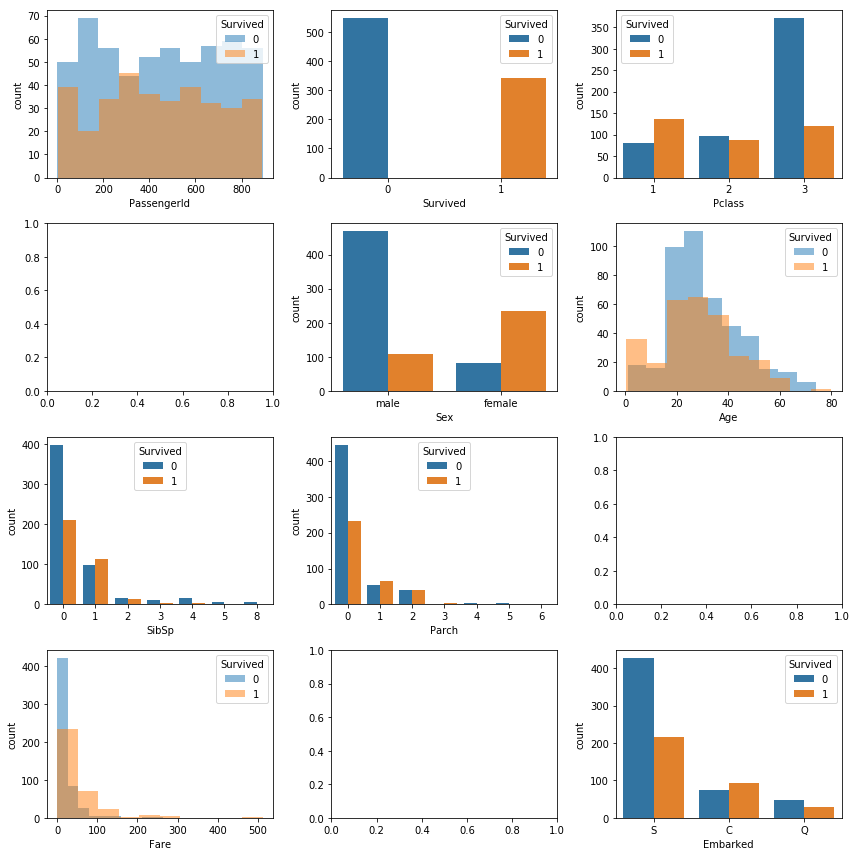

In [6]:
dispgraph.plot_all_distribution(train_data, "Survived")

### 性別により、生存率に差がある

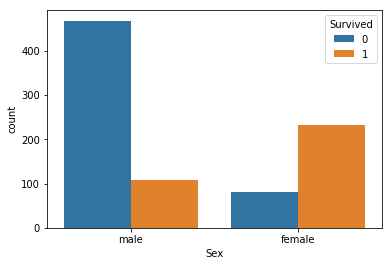

In [7]:
dispgraph.plot_distribution(train_data, "Sex", "Survived")

In [8]:
train_data.groupby(["Sex"])["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [9]:
male_data = train_data.loc[train_data["Sex"] == "male", "Survived"]
female_data = train_data.loc[train_data["Sex"] == "female", "Survived"]
res = stats.ttest_ind(male_data, female_data, equal_var = False)
res

Ttest_indResult(statistic=-18.67183317725917, pvalue=2.2836009226010537e-61)

### Nameから敬称を取り出す

In [10]:
train_data['Title'] = train_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
train_data['Title'] = train_data['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme':'Mrs'})
fixed_title = ["Mr", "Miss", "Mrs", "Master"]

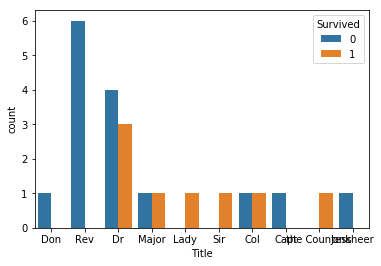

In [11]:
rare_title_data = train_data[~(train_data["Title"].isin(fixed_title))]
dispgraph.plot_distribution(rare_title_data, "Title", "Survived")

一般的でない敬称についてはデータ数が少ないため、Rareにまとめる

In [12]:
train_data.loc[~(train_data["Title"].isin(fixed_title)), "Title"] = "Rare"

敬称の違いにより、生存率に差がありそうである

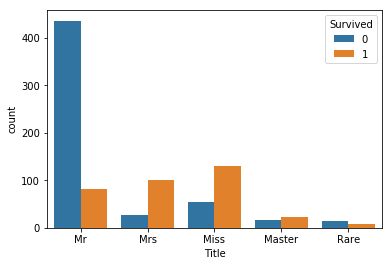

In [13]:
dispgraph.plot_distribution(train_data, "Title", "Survived")

In [14]:
pd.crosstab(train_data["Title"], train_data["Survived"])

Survived,0,1
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Rare,15,8


敬称と性別が正しく紐づいているか（誤りがないか）確認

In [15]:
pd.crosstab(train_data["Title"], train_data["Sex"])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


In [16]:
train_data.groupby(["Title"])["Survived"].mean()

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.347826
Name: Survived, dtype: float64

### MissとMrsでは、多少Mrsのほうが生存率が高い

In [17]:
from scipy import stats
miss_data = train_data.loc[train_data["Title"] == "Miss", "Survived"]
mrs_data = train_data.loc[train_data["Title"] == "Mrs", "Survived"]
res = stats.ttest_ind(miss_data, mrs_data, equal_var = False)
res

Ttest_indResult(statistic=-1.8391025418276266, pvalue=0.06692805935397572)

Mrsは、相対的に子供連れの人が多いから、子供と一緒に助られ生存率が高いのか検証する

### 親または子の同乗者数に限らず、Mrsの方が全体的に生存率は高い

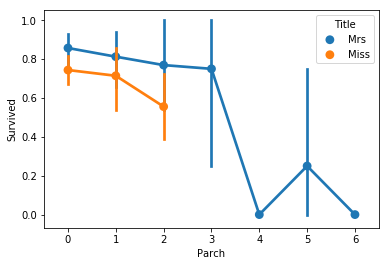

In [18]:
female_data = train_data[train_data["Sex"] == "female"]
female_data = female_data[female_data["Title"] != "Rare"]
sns.pointplot("Parch", "Survived", hue="Title", data=female_data)

### 男性の場合、親または子の同乗者が1～2名いるときに生存率が上がる

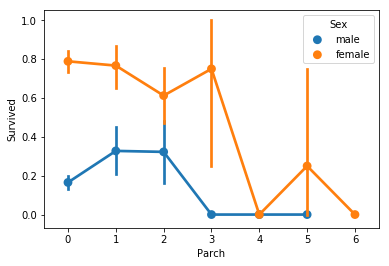

In [19]:
sns.pointplot("Parch", "Survived", hue="Sex", data=train_data)

兄弟の同乗者数はどんな特徴があるか次で確認する

### 兄弟の同乗者数についても、親または子の同乗者数と近い傾向がありそう

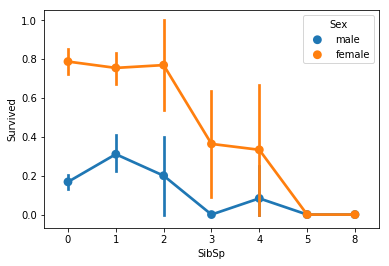

In [20]:
sns.pointplot("SibSp", "Survived", hue="Sex", data=train_data)

### 親/子、兄弟の同乗者数を合算した家族数で見るといくつかの傾向が見えてくる
* 男女関係なく、4人以上のとき生存率は下がる傾向がある。
* 女性は、0～3人はほとんど生存率に差がない
* 男性は、0～3人までは生存率が高くなっていく傾向がある。

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


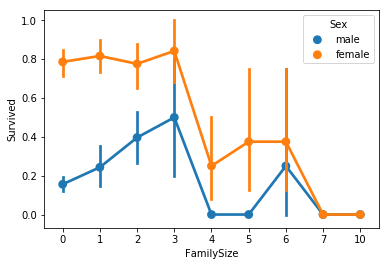

In [21]:
add_family_size = train_data[["Survived", "Sex"]]
add_family_size["FamilySize"] = train_data["Parch"] + train_data["SibSp"]
sns.pointplot("FamilySize", "Survived", hue="Sex", data=add_family_size)

### 男性の中でもMasterは生存率が高い

In [22]:
train_data.groupby(["Sex", "Title"])["Survived"].mean()

Sex     Title 
female  Miss      0.702703
        Mrs       0.793651
        Rare      1.000000
male    Master    0.575000
        Mr        0.156673
        Rare      0.250000
Name: Survived, dtype: float64

In [23]:
master_data = train_data.loc[train_data["Title"] == "Master", "Survived"]
mr_data = train_data.loc[train_data["Title"] == "Mr", "Survived"]
res = stats.ttest_ind(master_data, mr_data, equal_var = False)
res

Ttest_indResult(statistic=5.179913995771626, pvalue=5.842939487676502e-06)

### （Masterというよりは）年齢が低い子供の生存確率は高い（男性or女性関係なく）
* 他の年代はあまり生存率に差はなさそう

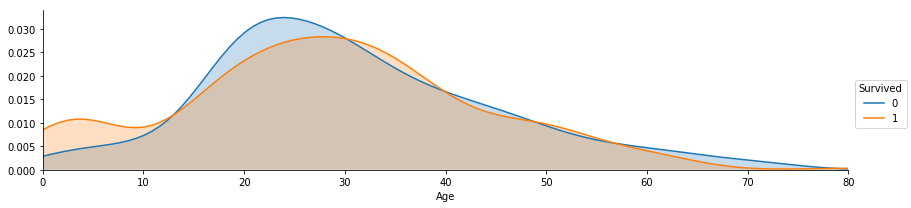

In [24]:
a = sns.FacetGrid(train_data, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_data['Age'].max()))
a.add_legend()

In [25]:
binned_age = train_data[["Age", "Sex", "Survived"]]
binned_age["binned_age"] = pd.cut(binned_age['Age'], 12)
binned_age.groupby(["Sex", "binned_age"]).agg({"Survived": ["count", "mean", "std"]})

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Survived                    
                           count      mean       std
Sex    binned_age                                   
female (0.34, 7.052]          24  0.750000  0.442326
       (7.052, 13.683]        10  0.300000  0.483046
       (13.683, 20.315]       43  0.744186  0.441481
       (20.315, 26.947]       50  0.740000  0.443087
       (26.947, 33.578]       49  0.775510  0.421570
       (33.578, 40.21]        37  0.864865  0.346583
       (40.21, 46.842]        18  0.611111  0.501631
       (46.842, 53.473]       17  0.823529  0.392953
       (53.473, 60.105]       10  0.900000  0.316228
       (60.105, 66.737]        3  1.000000  0.000000
male   (0.34, 7.052]          26  0.615385  0.496139
       (7.052, 13.683]        11  0.454545  0.522233
       (13.683, 20.315]       65  0.123077  0.331082
       (20.315, 26.947]       90  0.122222  0.329377
       (26.947, 33.578]       95  0.231579  0.424079
       (33.578, 40.21]        64  0.203125  0.405505
       (40.21, 46.842]        34  0.176471  0.386953
       (46.842, 53.473]       31  0.258065  0.444803
       (53.473, 60.105]       18  0.111111  0.323381
       (60.105, 66.737]       12  0.083333  0.288675
       (66.737, 73.368]        5  0.000000  0.000000
       (73.368, 80.0]          2  0.500000  0.707107

In [26]:
u12_data = train_data[train_data["Age"] <= 12]
u12_data.groupby(["Sex"])["Survived"].mean()

Sex
female    0.593750
male      0.567568
Name: Survived, dtype: float64

### TitleからAgeはある程度推測できそう

In [27]:
train_data.groupby("Title").agg({"Age":["mean", "std"]})

Age           
             mean        std
Title                       
Master   4.574167   3.619872
Miss    21.845638  12.870542
Mr      32.368090  12.708793
Mrs     35.788991  11.437490
Rare    45.545455  11.782664

### Pclassはグレードが高い方が生存率が高い
* 女性でもクラス3は生存率が半分程度まで下がる（クラス1,2はほとんど差がない）
* 男性は、クラス1では生存率が比較的高くなる

In [28]:
train_data.groupby(["Sex", "Pclass"]).agg({"Survived": ["count", "mean", "std"]})

Survived                    
                 count      mean       std
Sex    Pclass                             
female 1            94  0.968085  0.176716
       2            76  0.921053  0.271448
       3           144  0.500000  0.501745
male   1           122  0.368852  0.484484
       2           108  0.157407  0.365882
       3           347  0.135447  0.342694

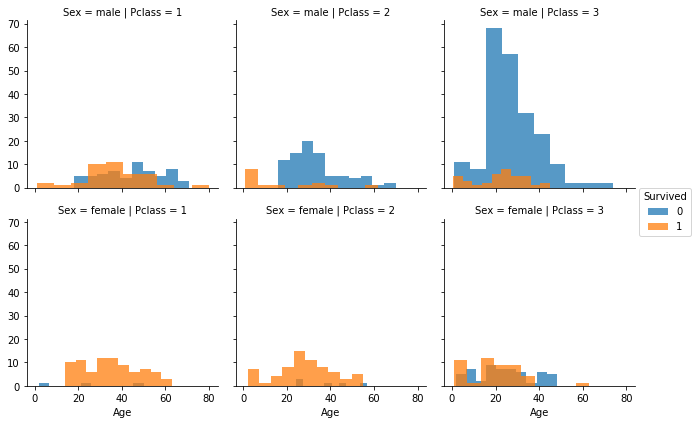

In [29]:
h = sns.FacetGrid(train_data, row = "Sex", col = "Pclass", hue = "Survived")
h.map(plt.hist, "Age", alpha = .75)
h.add_legend()

### Fareに比例して、多少生存率も高まる（Pclassと関連）

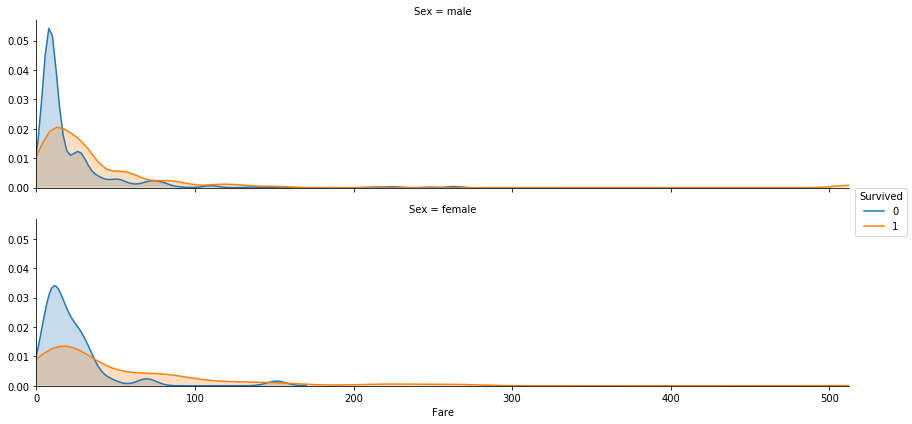

In [30]:
a = sns.FacetGrid(train_data, row = "Sex", hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Fare', shade= True )
a.set(xlim=(0 , train_data['Fare'].max()))
a.add_legend()

In [31]:
#pd.crosstab(pd.qcut(train_data["Fare"], 20), train_data["Survived"])
binned_fare = train_data[["Fare", "Sex", "Survived", "Pclass"]]
binned_fare["binned_fare"] = pd.cut(binned_fare['Fare'], 60)
binned_fare.groupby(["Sex", "binned_fare"]).agg({"Survived": ["count", "mean", "std"],
                                                 "Pclass": ["count", "mean", "std"]})

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Survived                     Pclass            \
                             count      mean       std  count      mean   
Sex    binned_fare                                                        
female (-0.512, 8.539]          52  0.653846  0.480384     52  3.000000   
       (8.539, 17.078]          79  0.670886  0.472894     79  2.594937   
       (17.078, 25.616]         36  0.611111  0.494413     36  2.694444   
       (25.616, 34.155]         46  0.739130  0.443961     46  2.065217   
       (34.155, 42.694]         10  0.600000  0.516398     10  2.200000   
       (42.694, 51.233]          4  0.500000  0.577350      4  2.000000   
       (51.233, 59.772]         15  1.000000  0.000000     15  1.000000   
       (59.772, 68.311]          3  1.000000  0.000000      3  1.666667   
       (68.311, 76.849]         10  0.700000  0.483046     10  1.600000   
       (76.849, 85.388]         16  1.000000  0.000000     16  1.000000   
       (85.388, 93.927]          9  1.000000  0.000000      9  1.000000   
       (102.466, 111.005]        4  1.000000  0.000000      4  1.000000   
       (111.005, 119.543]        2  1.000000  0.000000      2  1.000000   
       (119.543, 128.082]        2  1.000000  0.000000      2  1.000000   
       (128.082, 136.621]        5  1.000000  0.000000      5  1.000000   
       (145.16, 153.699]         7  0.714286  0.487950      7  1.000000   
       (162.238, 170.776]        2  1.000000  0.000000      2  1.000000   
       (204.932, 213.47]         3  1.000000  0.000000      3  1.000000   
       (222.009, 230.548]        3  1.000000  0.000000      3  1.000000   
       (239.087, 247.626]        1  1.000000       NaN      1  1.000000   
       (256.165, 264.703]        4  1.000000  0.000000      4  1.000000   
       (503.79, 512.329]         1  1.000000       NaN      1  1.000000   
male   (-0.512, 8.539]         242  0.107438  0.310311    242  2.925620   
       (8.539, 17.078]         123  0.154472  0.362878    123  2.504065   
       (17.078, 25.616]         30  0.200000  0.406838     30  2.733333   
       (25.616, 34.155]         79  0.316456  0.468065     79  1.569620   
       (34.155, 42.694]         23  0.260870  0.448978     23  1.826087   
       (42.694, 51.233]          8  0.000000  0.000000      8  2.000000   
       (51.233, 59.772]         22  0.545455  0.509647     22  1.636364   
       (59.772, 68.311]          5  0.200000  0.447214      5  1.000000   
       (68.311, 76.849]         12  0.166667  0.389249     12  2.083333   
       (76.849, 85.388]         10  0.200000  0.421637     10  1.000000   
       (85.388, 93.927]          4  0.750000  0.500000      4  1.000000   
       (102.466, 111.005]        4  0.250000  0.500000      4  1.000000   
       (111.005, 119.543]        1  0.000000       NaN      1  1.000000   
       (119.543, 128.082]        2  1.000000  0.000000      2  1.000000   
       (128.082, 136.621]        2  0.500000  0.707107      2  1.000000   
       (145.16, 153.699]         2  0.500000  0.707107      2  1.000000   
       (204.932, 213.47]         1  0.000000       NaN      1  1.000000   
       (213.47, 222.009]         1  0.000000       NaN      1  1.000000   
       (222.009, 230.548]        1  0.000000       NaN      1  1.000000   
       (239.087, 247.626]        1  0.000000       NaN      1  1.000000   
       (256.165, 264.703]        2  0.000000  0.000000      2  1.000000   
       (503.79, 512.329]         2  1.000000  0.000000      2  1.000000   

                                     
                                std  
Sex    binned_fare                   
female (-0.512, 8.539]     0.000000  
       (8.539, 17.078]     0.494041  
       (17.078, 25.616]    0.467177  
       (25.616, 34.155]    0.646432  
       (34.155, 42.694]    0.788811  
       (42.694, 51.233]    1.154701  
       (51.233, 59.772]    0.000000  
       (59.772, 68.311]    0.577350  
       (68.311, 76.849]    0.966092  
       (76.849, 85.388]    0.000000  
      

In [32]:
train_data.groupby("Pclass").agg({"Fare":["mean", "std"]})

Fare           
             mean        std
Pclass                      
1       84.154687  78.380373
2       20.662183  13.417399
3       13.675550  11.778142

### Cabinは欠損している場合、生存率は下がる

In [33]:
train_data["Cabin"].isnull().sum()

687

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tomiyou\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\tomiyou\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


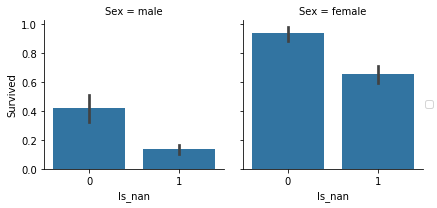

In [34]:
cabin_data = train_data[["Cabin", "Sex", "Survived"]]
cabin_data["Is_nan"] = 0
cabin_data.loc[cabin_data["Cabin"].isnull(), "Is_nan"] = 1
#sns.barplot("is_nan", "Survived", data=cabin_data)
a = sns.FacetGrid(cabin_data, col = "Sex")
a.map(sns.barplot, "Is_nan", "Survived", )
a.add_legend()

Cabinの頭文字が船内の区画を表している？そうであれば、生存率の高い区画があるかもしれない

In [35]:
train_data["Cabin"].value_counts()

C23 C25 C27        4
B96 B98            4
G6                 4
D                  3
E101               3
F33                3
C22 C26            3
F2                 3
E121               2
B77                2
D17                2
F G73              2
C125               2
F4                 2
B22                2
C83                2
E67                2
E25                2
E24                2
C123               2
E44                2
B57 B59 B63 B66    2
C2                 2
C65                2
E33                2
C126               2
B58 B60            2
C93                2
C78                2
D33                2
                  ..
B37                1
D21                1
B42                1
A24                1
B71                1
C86                1
C95                1
C50                1
F G63              1
C91                1
C87                1
B39                1
C49                1
B78                1
D56                1
A23                1
A16          

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\tomiyou\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin_cap, dtype: int64


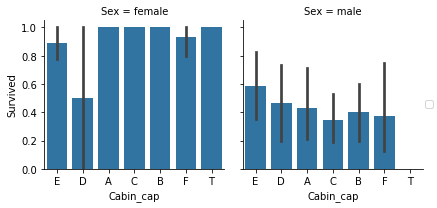

In [36]:
#頭文字を取り出す
cabin_data = train_data[["Cabin", "Sex", "Survived"]]
cabin_data.dropna(inplace=True)
cabin_data["Cabin_cap"] = cabin_data["Cabin"].apply(lambda x: str(x)[0])
print(cabin_data["Cabin_cap"].value_counts())
a = sns.FacetGrid(cabin_data, col = "Sex")
a.map(sns.barplot, "Cabin_cap", "Survived", )
a.add_legend()

各Cabinの生存率の違いはいまいち解釈しにくいので、予測には使わないこととする

### Ticket

In [37]:
ticket_data = train_data["Ticket"].apply(lambda x:str(x).rsplit(" ", 1))
ticket_data = pd.DataFrame({"Ticket_0":ticket_data.apply(lambda x: x[0] if len(x) > 1 else ""),
                            "Ticket_1":ticket_data.apply(lambda x: x[1] if len(x) > 1 else x[0])})
ticket_data["Survived"] = train_data["Survived"]
ticket_data["Fare"] = train_data["Fare"]
ticket_data["Sex"] = train_data["Sex"]
ticket_data["Pclass"] = train_data["Pclass"]
ticket_data.head()

,Ticket_0,Ticket_1,Survived,Fare,Sex,Pclass
0,A/5,21171,0,7.2500,male,3
1,PC,17599,1,71.2833,female,1
2,STON/O2.,3101282,1,7.9250,female,3
3,,113803,1,53.1000,female,1
4,,373450,0,8.0500,male,3


In [38]:
ticket_data["Ticket_0"].value_counts()

               665
PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
CA.              8
SOTON/O.Q.       8
SOTON/OQ         7
A/5.             7
STON/O2.         6
CA               6
F.C.C.           5
S.O.C.           5
SC/PARIS         5
C                5
SC/Paris         4
A/4              3
S.O./P.P.        3
A/4.             3
PP               3
A./5.            2
SC/AH            2
A.5.             2
S.C./PARIS       2
P/PP             2
SOTON/O2         2
WE/P             2
SC               1
W/C              1
S.W./PP          1
A4.              1
S.O.P.           1
SC/AH Basle      1
S.C./A.4.        1
Fa               1
SW/PP            1
S.P.             1
W.E.P.           1
SO/C             1
F.C.             1
C.A./SOTON       1
A/S              1
SCO/W            1
Name: Ticket_0, dtype: int64

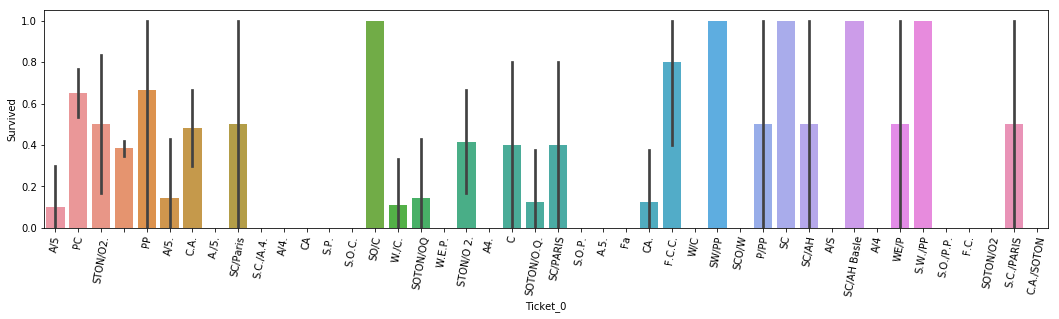

In [39]:
plt.figure(figsize=(18,4))
plt.xticks(rotation=80)
sns.barplot("Ticket_0", "Survived", data=ticket_data)

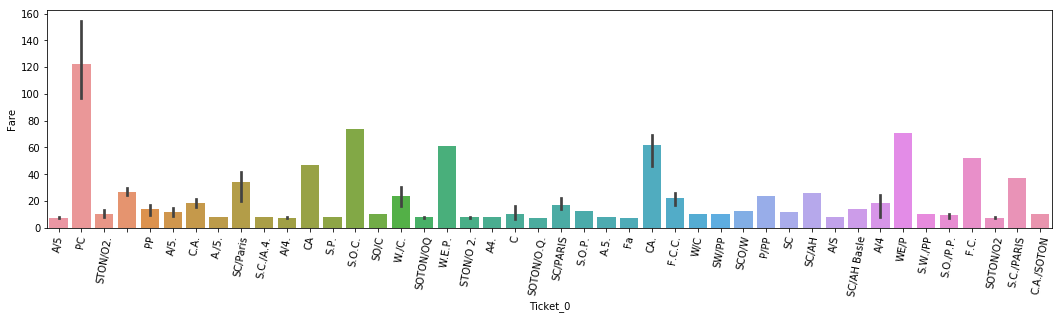

In [40]:
plt.figure(figsize=(18,4))
plt.xticks(rotation=80)
sns.barplot("Ticket_0", "Fare", data=ticket_data)

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


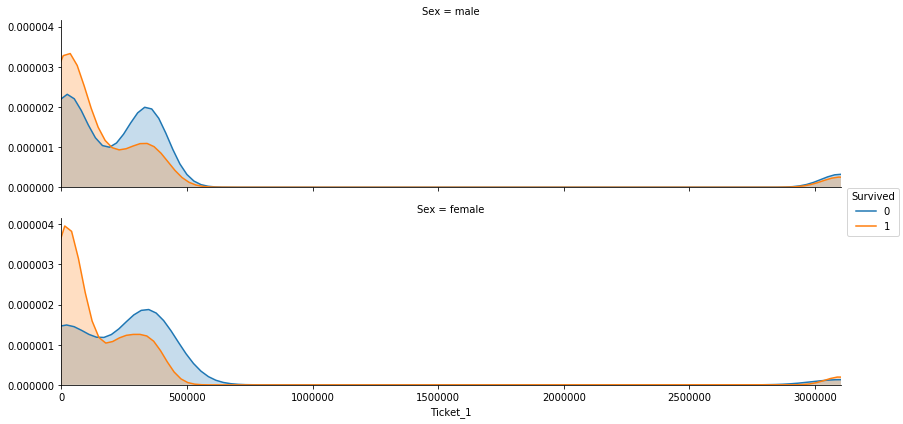

In [41]:
ticket_data_num = ticket_data[ticket_data["Ticket_1"] != "LINE"]
ticket_data_num["Ticket_1"] = ticket_data_num["Ticket_1"].astype(int)
a = sns.FacetGrid(ticket_data_num, row = "Sex", hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Ticket_1', shade= True )
a.set(xlim=(0 , ticket_data_num['Ticket_1'].max()))
a.add_legend()

C:\Users\tomiyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


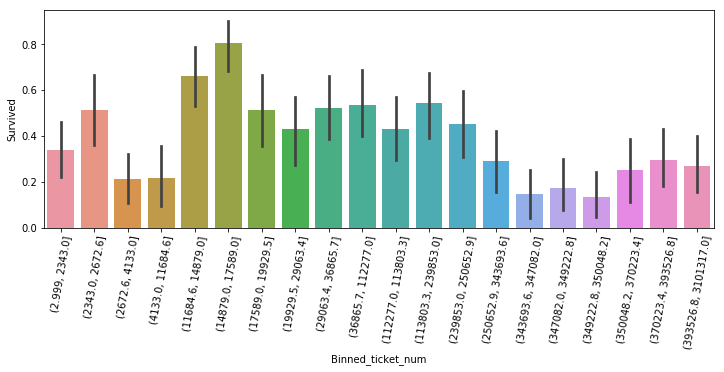

In [42]:
binned_ticket_num = ticket_data_num[["Ticket_1", "Sex", "Fare", "Survived"]]
binned_ticket_num["Binned_ticket_num"] = pd.qcut(ticket_data_num["Ticket_1"], 20)
plt.figure(figsize=(12,4))
plt.xticks(rotation=80)
sns.barplot("Binned_ticket_num", "Survived", data=binned_ticket_num)

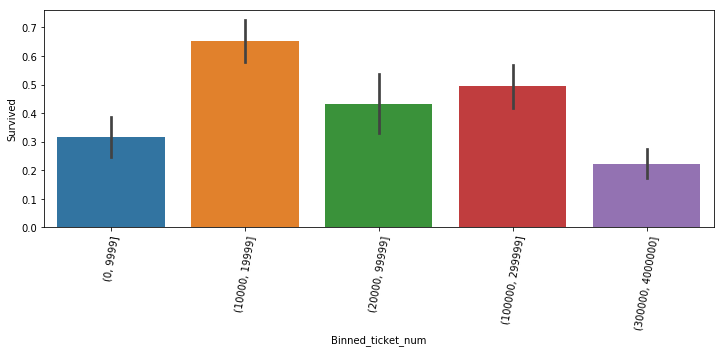

In [43]:
binned_ticket_num = ticket_data_num[["Ticket_1", "Sex", "Fare", "Pclass", "Survived"]]
bins = pd.IntervalIndex.from_tuples([(0, 9999), (10000, 19999), (20000, 99999), (100000, 299999),(300000,4000000)])
binned_ticket_num["Binned_ticket_num"] = pd.cut(ticket_data_num["Ticket_1"], bins=bins)
plt.figure(figsize=(12,4))
plt.xticks(rotation=80)
sns.barplot("Binned_ticket_num", "Survived", data=binned_ticket_num)

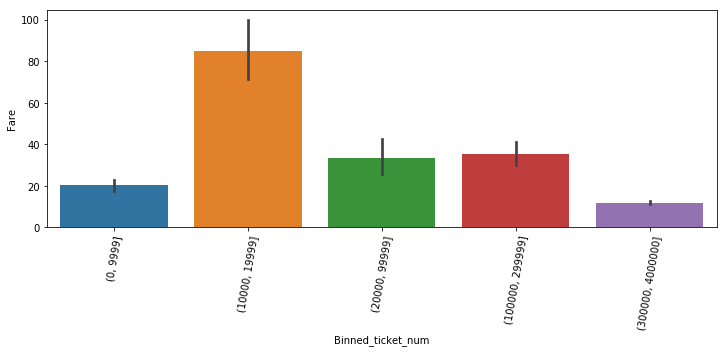

In [44]:
plt.figure(figsize=(12,4))
plt.xticks(rotation=80)
sns.barplot("Binned_ticket_num", "Fare", data=binned_ticket_num)

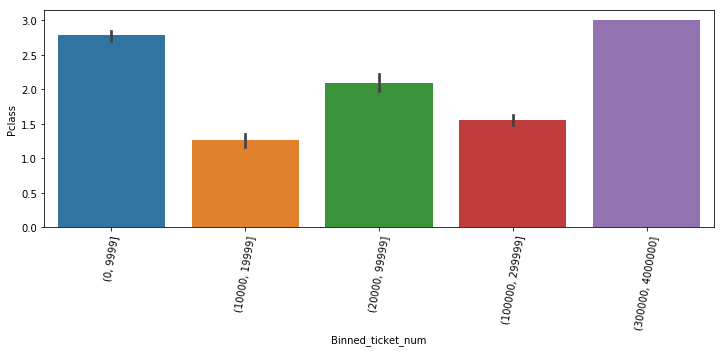

In [45]:
plt.figure(figsize=(12,4))
plt.xticks(rotation=80)
sns.barplot("Binned_ticket_num", "Pclass", data=binned_ticket_num)

In [46]:
ticket_data[ticket_data["Ticket_1"] == "LINE"]

,Ticket_0,Ticket_1,Survived,Fare,Sex,Pclass
179,,LINE,0,0.0,male,3
271,,LINE,1,0.0,male,3
302,,LINE,0,0.0,male,3
597,,LINE,0,0.0,male,3


### Embarkedは、C＞Q>Sの順に生存率が高い
* この関係は、概ねFareに紐づいている(C＞S＞Q)のだが、SとQについてはFareの大小関係と逆転している

In [47]:
train_data["Embarked"].isnull().sum()

2

C:\Users\tomiyou\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


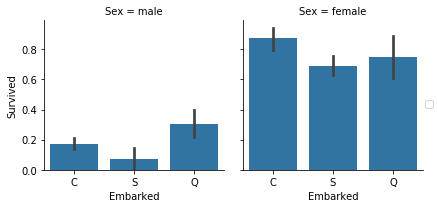

In [48]:
a = sns.FacetGrid(train_data, col = "Sex")
a.map(sns.barplot, "Embarked", "Survived", )
a.add_legend()

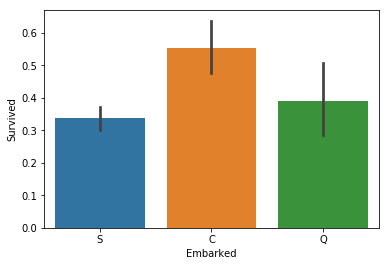

In [49]:
sns.barplot("Embarked", "Survived", data=train_data)

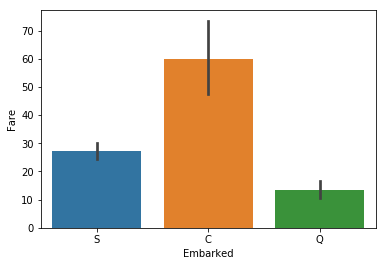

In [50]:
sns.barplot("Embarked", "Fare", data=train_data)

In [51]:
train_data.groupby("Embarked")["Fare"].mean()

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

Embarkedは、Fareからも予測できそうである